In [5]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [6]:
import os
os.listdir("gdrive/MyDrive/grozi_coco/train2017")



['259.jpg',
 '517.jpg',
 '271.jpg',
 '270.jpg',
 '265.jpg',
 '305.jpg',
 '477.jpg',
 '516.jpg',
 '295.jpg',
 '134.jpg',
 '120.jpg',
 '38.jpg',
 '10.jpg',
 '105.jpg',
 '108.jpg',
 '677.jpg',
 '111.jpg',
 '307.jpg',
 '35.jpg',
 '139.jpg',
 '663.jpg',
 '313.jpg',
 '461.jpg',
 '273.jpg',
 '267.jpg',
 '475.jpg',
 '501.jpg',
 '529.jpg',
 '528.jpg',
 '449.jpg',
 '298.jpg',
 '266.jpg',
 '500.jpg',
 '514.jpg',
 '515.jpg',
 '272.jpg',
 '299.jpg',
 '138.jpg',
 '662.jpg',
 '448.jpg',
 '676.jpg',
 '474.jpg',
 '460.jpg',
 '110.jpg',
 '312.jpg',
 '306.jpg',
 '39.jpg',
 '104.jpg',
 '13.jpg',
 '489.jpg',
 '112.jpg',
 '660.jpg',
 '648.jpg',
 '476.jpg',
 '310.jpg',
 '674.jpg',
 '106.jpg',
 '462.jpg',
 '338.jpg',
 '304.jpg',
 '502.jpg',
 '258.jpg',
 '264.jpg',
 '645.jpg',
 '651.jpg',
 '36.jpg',
 '20.jpg',
 '34.jpg',
 '109.jpg',
 '137.jpg',
 '647.jpg',
 '121.jpg',
 '135.jpg',
 '653.jpg',
 '679.jpg',
 '479.jpg',
 '445.jpg',
 '531.jpg',
 '451.jpg',
 '257.jpg',
 '519.jpg',
 '525.jpg',
 '243.jpg',
 '242.jpg',


In [7]:
def get_image_file_path(image_file_name):
    """returns the path of image file"""
    return 'gdrive/MyDrive/grozi_coco/train2017' + image_file_name

def get_images(n):
    """reads all the files from `../input/test` directory and returns paths for n files from top"""
    all_image_files = os.listdir("gdrive/MyDrive/grozi_coco/train2017")
    # let's save all these image paths for later
    image_paths = list(map(get_image_file_path, all_image_files))
    # rather than using all, we will use a subset of these image paths for working on our model
    image_paths = image_paths[:n]
    return image_paths

def get_image_id_from_path(image_path):
    """returns image id from image path"""
    return image_path.split('gdrive/MyDrive/grozi_coco/train2017')[1].split('.jpg')[0]

In [8]:
print(get_images(10))
print(get_image_id_from_path(get_images(2)[0]))

['gdrive/MyDrive/grozi_coco/train2017259.jpg', 'gdrive/MyDrive/grozi_coco/train2017517.jpg', 'gdrive/MyDrive/grozi_coco/train2017271.jpg', 'gdrive/MyDrive/grozi_coco/train2017270.jpg', 'gdrive/MyDrive/grozi_coco/train2017265.jpg', 'gdrive/MyDrive/grozi_coco/train2017305.jpg', 'gdrive/MyDrive/grozi_coco/train2017477.jpg', 'gdrive/MyDrive/grozi_coco/train2017516.jpg', 'gdrive/MyDrive/grozi_coco/train2017295.jpg', 'gdrive/MyDrive/grozi_coco/train2017134.jpg']
259


In [9]:
def get_prediction_string(result):
    with tf.device('/device:GPU:0'):
        """from each result, generates the complete prediction string in the format {Label Confidence XMin YMin XMax YMax},{...} based on submission file."""
        prediction_strings = []
        for index, score in enumerate(result['detection_scores']):
            index = int(index)
            single_prediction_string = ""
            single_prediction_string += result['detection_class_names'][index].decode("utf-8") + " "  + str(score) + " "
            single_prediction_string += " ".join(str(x) for x in result['detection_boxes'][index])
            prediction_strings.append(single_prediction_string)

        prediction_string = " ".join(str(x) for x in prediction_strings)
        return prediction_string

def get_prediction_entry(filepath, result):
    return {
        "ImageID": get_image_id_from_path(filepath),
        "PredictionString": get_prediction_string(result)
    }

In [10]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
from six import BytesIO

# For drawing onto the image.
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())


The following GPU devices are available: 


In [12]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def draw_bounding_box_on_image(image,ymin,xmin,ymax,
                               xmax,color,font,thickness=4,display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)],width=thickness,
              fill=color)
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
            25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil,
                ymin,xmin,ymax,xmax,color,font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [23]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
image_path = "gdrive/MyDrive/grozi_coco/train2017/0.jpg"

with tf.device('/device:GPU:0'):
    with tf.Graph().as_default():
        detector = hub.Module(module_handle)
        image_string_placeholder = tf.compat.v1.placeholder(tf.string)
        decoded_image = tf.image.decode_jpeg(image_string_placeholder)
        # Module accepts as input tensors of shape [1, height, width, 3], i.e. batch
        # of size 1 and type tf.float32.
        decoded_image_float = tf.image.convert_image_dtype(
            image=decoded_image, dtype=tf.float32)
        module_input = tf.expand_dims(decoded_image_float, 0)
        result = detector(module_input, as_dict=True)
        init_ops = [tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()]

        session = tf.compat.v1.Session()
        session.run(init_ops)

        # Load the downloaded and resized image and feed into the graph.
        with tf.compat.v1.gfile.Open(image_path, "rb") as binfile:
            image_string = binfile.read()

        result_out, image_out = session.run(
            [result, decoded_image],
            feed_dict={image_string_placeholder: image_string})
        print("Found %d objects." % len(result_out["detection_scores"]))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.


0.8368175029754639


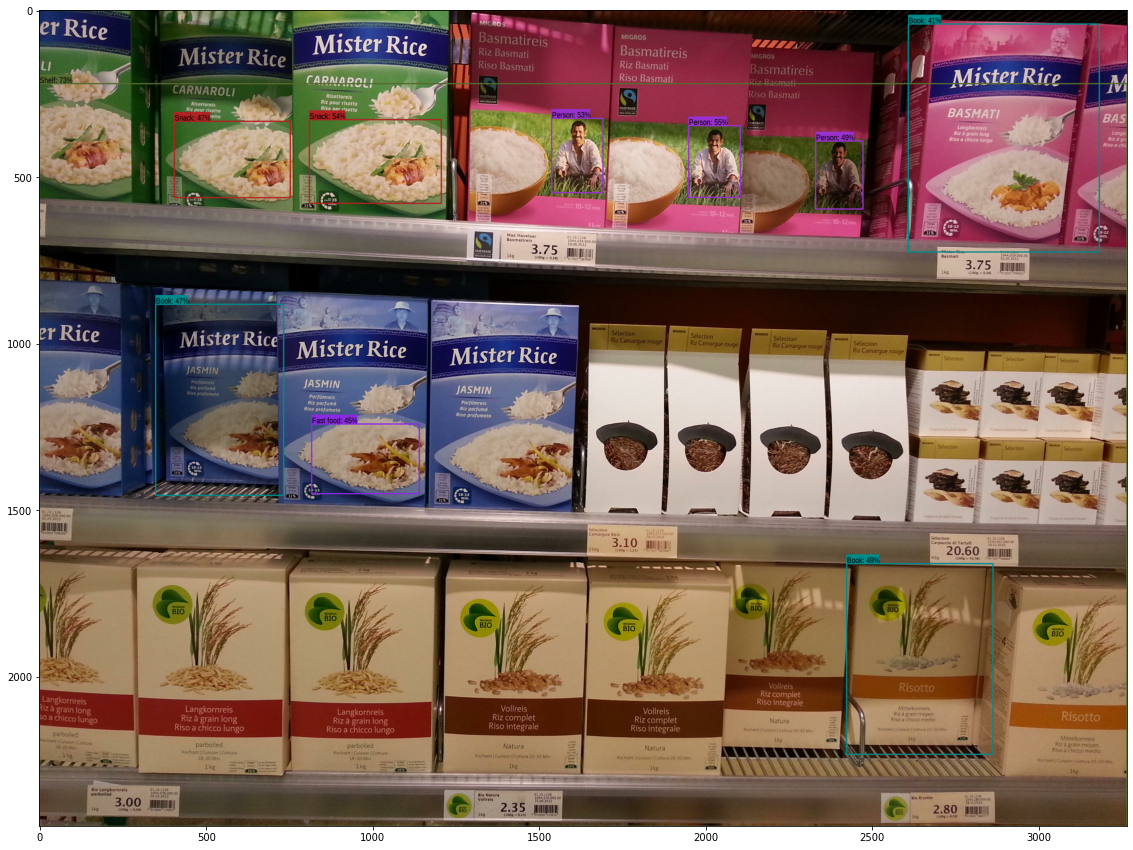

In [24]:
import time
begin = time.time()
# see the sample image with bounding boxes
image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])
display_image(image_with_boxes)

end = time.time()
print(end-begin)